## python code to compute midbrain contrast

for more information see:

    Trutti, A. C., Fontanesi, L., Mulder, M. J., Bazin, P. L., Hommel, B., & Forstmann, B. U. (2021). A probabilistic atlas of the human ventral tegmental area (VTA) based on 7 Tesla MRI data. Brain Structure and Function, 226(4), 1155–1167. https://doi.org/10.1007/s00429-021-02231-w

In [3]:
import nibabel as nb
import numpy as np
import nilearn as nl
import os

from nilearn.image import mean_img  # meanImg
from nilearn.plotting import  glass_brain, plot_anat, plot_epi
from nilearn import image, plotting
import intensity_normalization

import matplotlib.pyplot as plt  # Matplotlib is a plotting library




### preprocessing steps involved:  

1. reorient images 
2. skull-strip images
3. make midbrain masks
4. rename files according to BIDS format
 


Text(0.5, 0.98, 'Center slices for EPI image')

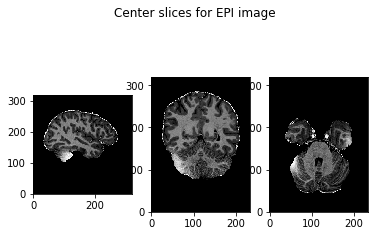

In [8]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = dataT1[60, :, :]
slice_1 = dataT1[:, 100, :]
slice_2 = dataT1[:, :, 125]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")  # doctest: +SKIP

## midbrain contrast computation

make list of subjects

In [47]:
subjects = ['sub-xxx']


loop through subjects and compute final midbrain contrast

In [ ]:

for subject_id in subjects:
    print(subject_id)
    main_dir = '../HumanAtlas_BIDS' #path to main data dir
    sub_dir = main_dir +'/'+ str(subject_id)
    save_dir =  sub_dir  +'/'+ 'ses-1/derivatives/vta/midbrain_contrast'
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
   # print(sub_dir)
    
    # load individual reoriented and bet images 
    # no. 1 = t1-weighted image 
    imgT1 = nb.load(sub_dir + '/' +  'ses-1/anat/wb/bet/' + str(subject_id) + '_ses-1_acq-wb_mod-t1w_orient-std_brain.nii.gz') 
    # no. 2 = 3rd echo of second inversion  
    imgE3 = nb.load(sub_dir + '/' +  'ses-1/anat/wb/bet/' + str(subject_id) + '_ses-1_acq-wb_inv-2_echo-3_part-mag_mprage_orient-std_brain.nii.gz')
    # no. 3 = 4th echo of second inversion  
    imgE4 = nb.load(sub_dir + '/' +  'ses-1/anat/wb/bet/' + str(subject_id) + '_ses-1_acq-wb_inv-2_echo-4_part-mag_mprage_orient-std_brain.nii.gz')

    T1_data = imgT1.get_fdata()
    E3_data = imgE3.get_fdata()
    E4_data = imgE4.get_fdata()
    
    
    #compute mean echo image
    meanEcho = np.add(E3_data,E4_data)/2.0#, dtype=np.float32)
    #make it a nifti object again
    meanEcho_nii = nb.Nifti1Image(meanEcho, affine=imgE3.affine)
    
    
    #load midbrain mask for ind. subject
    midbrain_mask = nb.load(sub_dir + '/' +  'ses-1/derivatives/vta/midbrain_mask/'+ str(subject_id) + '_ses-1_acq-wb_midbrain_mask.nii.gz')
    mask_data = midbrain_mask.get_fdata()
    
    
    #mask images
    #1 mean echoes
    masked_echoes = meanEcho.copy()
    masked_echoes[mask_data==0] = 0
    #store as nifti object
    masked_echoes_nii = nb.Nifti1Image(masked_echoes, affine=imgE3.affine)
    
    #2 T1w image
    masked_T1w = T1_data.copy()
    masked_T1w[mask_data==0] = 0
    masked_T1w_nii = nb.Nifti1Image(masked_T1w, affine=imgT1.affine)
    
    
    #normalise instensities inside midbrain mask
    norm_meanEcho_masked_nii = intensity_normalization.normalize.zscore.zscore_normalize(masked_echoes_nii, mask = None)
    norm_t1_masked_nii = intensity_normalization.normalize.zscore.zscore_normalize(masked_T1w_nii, mask = None)
    
    #transform to array so you can run the maths
    final_echo_data = norm_meanEcho_masked_nii.get_fdata()
    final_T1w_data = norm_t1_masked_nii.get_fdata()

    #sum up the two normalised            images                             
    midbrain_contrast = np.add(final_echo_data,final_T1w_data)
    
    #transform final midbrain_contrast array back to Nifti image 
    midbrain_contrast_nii = nb.Nifti1Image(midbrain_contrast, affine=imgE3.affine)
    
    #label file
    fn = str(subject_id) + '_ses-1_acq-wb_midbrain_contrast'
    
    #save file
    nb.save(midbrain_contrast_nii, save_dir +'/'+ fn +'.nii.gz' )

    


## check out the computed image

In [58]:
midb_contrast = nb.load('../HumanAtlas_BIDS/sub-xxx/ses-1/derivatives/vta/midbrain_contrast/sub-xxx_ses-1_acq-wb_midbrain_contrast.nii.gz')

In [59]:
midb_data = midb_contrast.get_fdata()

(-0.5, 233.5, -0.5, 319.5)

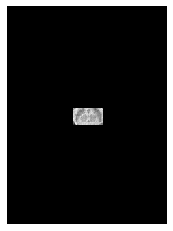

In [62]:
plt.imshow(midb_data[:,:,160].T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
#plt.show()

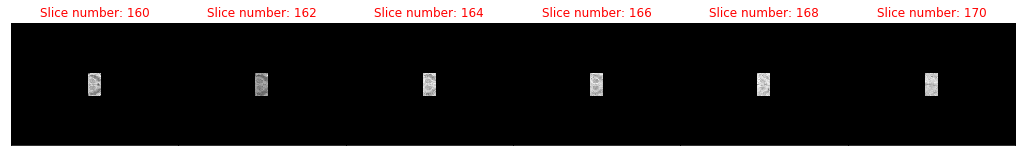

In [67]:

fig, ax = plt.subplots(1, 6, figsize=[18, 3])

n = 0
slice = 160
for _ in range(6):
    ax[n].imshow(midb_data[:, :, slice], 'gray')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
    ax[n].set_title('Slice number: {}'.format(slice), color='r')
    n += 1
    slice += 2
  
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()